In [95]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Machine Learning imports 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso

from sklearn.cross_validation import train_test_split
from sklearn import metrics

from sklearn.cross_validation import cross_val_score

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import skew

In [873]:
train = pd.read_csv("ad_org_train.csv")
test = pd.read_csv("ad_org_test.csv")
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [874]:
columns = ['views', 'likes', 'dislikes', 'comment']
for column in columns:
        train[column] = train[column].apply(pd.to_numeric, errors = 'coerce')
        test[column] = test[column].apply(pd.to_numeric, errors = 'coerce')        
        print (column, train[column].isnull().sum())
        print (column, test[column].isnull().sum())

views 2
views 1
likes 155
likes 88
dislikes 155
dislikes 88
comment 233
comment 151


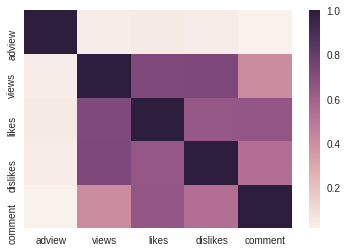

In [875]:
sns.heatmap(train.corr())

In [876]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [877]:
def time_transform(data):
    duration = data['duration']
    h_pos = 0
    m_pos = 0
    s_pos = len(duration) - 1
    time = 0
    #duration = list(duration)
    if 'H' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'H':
                h_pos = i
                break
        time = int(duration[2:h_pos]) * 3600 

    if 'M' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'M':
                m_pos = i
                break
        if 'H' in duration:
            time = time + int(duration[h_pos+1:m_pos]) * 60
        else:
            time = int(duration[2:m_pos]) * 60
        
        if 'S' in duration:
            time = time + int(duration[m_pos+1:s_pos])
        
    else:
        if 'H' not in duration:
            time = time + int(duration[2:s_pos])
        else:
            time = time + int(duration[h_pos+1:s_pos])
    #print (duration, m_pos)
    #time = str(time)
    #print (time)
    data['duration'] = time
    data.head()
    return data

train = train.apply(time_transform, axis=1)
test = test.apply(time_transform, axis=1)

dummies = pd.get_dummies(train.category)
train = train.join(dummies)
test = test.join(dummies)

train.drop(['category'], axis=1,inplace=True)
test.drop(['category'],axis=1, inplace=True)
train.head()

In [878]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['category'].values))
train['category'] = lbl.transform(list(train['category'].values))
test['category'] = lbl.transform(list(test['category'].values))

In [879]:
train['published'] = pd.to_datetime(train['published'])
test['published'] = pd.to_datetime(test['published'])

train['dayofweek'] = train.published.dt.dayofweek
test['dayofweek'] = test.published.dt.dayofweek
#quarter didn't work
#weekofyear didn't work

train['year'] = train.published.dt.year
test['year'] = test.published.dt.year

train['month'] = train.published.dt.month
test['month'] = test.published.dt.month

train.drop(['published'], axis=1, inplace=True)
test.drop(['published'], axis=1, inplace=True)

In [880]:
test.drop(['vidid'], axis=1, inplace=True)
train.drop(['vidid'], axis=1, inplace=True)

In [881]:
train.head()

,adview,views,likes,dislikes,comment,duration,category,dayofweek,year,month
0,40,1031602.0,8523.0,363.0,1095.0,457,5,2,2016,9
1,2,1707.0,56.0,2.0,6.0,570,3,5,2016,10
2,1,2023.0,25.0,0.0,2.0,136,2,5,2016,7
3,6,620860.0,777.0,161.0,153.0,262,7,2,2016,7
4,1,666.0,1.0,0.0,0.0,31,3,2,2016,6


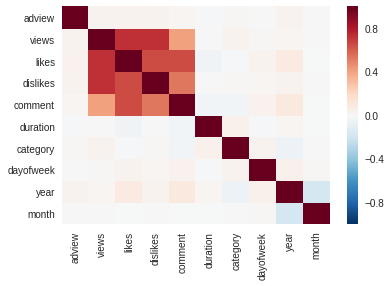

In [882]:
sns.heatmap(train.corr())

columns = ['adview', 'views', 'likes', 'dislikes', 'comment']
for x in columns:
    temp = train[x]
    mean = temp.mean()
    std = temp.std()
    final_list = [z for z in temp if (z > mean - 4 * std)]
    final_list = [z for z in final_list if (z < mean + 4*std)]
    temp = Series(final_list)
    train[x] = temp
    print (x, train[x].isnull().sum())

In [883]:
train.shape

(14637, 10)

In [884]:
train.dropna(inplace=True)

In [885]:
train.shape

(14637, 10)

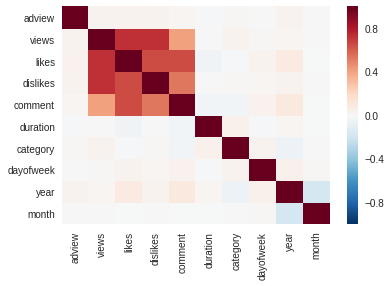

In [886]:
sns.heatmap(train.corr())

In [887]:
columns = ['adview','views', 'likes', 'dislikes', 'comment', 'duration']

std_scaler = preprocessing.StandardScaler()
std_scaler.fit(train[columns])
train[columns] = std_scaler.transform(train[columns])

In [888]:
for x in columns:
    train[x] = np.log1p(train[x])

In [889]:
train.head()

,adview,views,likes,dislikes,comment,duration,category,dayofweek,year,month
0,3.713572,13.846624,9.050641,5.897154,6.999422,6.126869,5,2,2016,9
1,1.098612,7.443078,4.043051,1.098612,1.945910,6.347389,3,5,2016,10
2,0.693147,7.612831,3.258097,0.000000,1.098612,4.919981,2,5,2016,7
3,1.945910,13.338863,6.656727,5.087596,5.036953,5.572154,7,2,2016,7
4,0.693147,6.502790,0.693147,0.000000,0.000000,3.465736,3,2,2016,6


In [890]:
train['v_l_r'] = train['views'] / train['likes']
train['v_dur_r'] = train['views'] / train['duration']
train['l_dis_r'] = train['likes'] / train['dislikes']
train['l_dur_r'] = train['likes'] / train['duration']
train['l_dur_p'] = train['likes'] * train['duration']

In [891]:
train.head()

,adview,views,likes,dislikes,comment,duration,category,dayofweek,year,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p
0,3.713572,13.846624,9.050641,5.897154,6.999422,6.126869,5,2,2016,9,1.529905,2.259984,1.534747,1.477205,55.452093
1,1.098612,7.443078,4.043051,1.098612,1.945910,6.347389,3,5,2016,10,1.840956,1.172620,3.680144,0.636963,25.662820
2,0.693147,7.612831,3.258097,0.000000,1.098612,4.919981,2,5,2016,7,2.336589,1.547329,inf,0.662217,16.029773
3,1.945910,13.338863,6.656727,5.087596,5.036953,5.572154,7,2,2016,7,2.003817,2.393843,1.308423,1.194642,37.092306
4,0.693147,6.502790,0.693147,0.000000,0.000000,3.465736,3,2,2016,6,9.381543,1.876309,inf,0.200000,2.402265


In [892]:
train = train.replace([np.inf, -np.inf], np.NaN)

In [893]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14637 entries, 0 to 14998
Data columns (total 15 columns):
adview       14637 non-null float64
views        14637 non-null float64
likes        14637 non-null float64
dislikes     14637 non-null float64
comment      14637 non-null float64
duration     14637 non-null float64
category     14637 non-null int64
dayofweek    14637 non-null int64
year         14637 non-null int64
month        14637 non-null int64
v_l_r        14469 non-null float64
v_dur_r      14636 non-null float64
l_dis_r      13548 non-null float64
l_dur_r      14636 non-null float64
l_dur_p      14637 non-null float64
dtypes: float64(11), int64(4)
memory usage: 1.8 MB


In [894]:
train.v_l_r.fillna(train.v_l_r.mean(), inplace=True)
train.v_dur_r.fillna(train.v_dur_r.mean(), inplace=True)
train.l_dis_r.fillna(train.l_dis_r.mean(), inplace=True)
train.l_dur_r.fillna(train.l_dur_r.mean(), inplace=True)

In [895]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14637 entries, 0 to 14998
Data columns (total 15 columns):
adview       14637 non-null float64
views        14637 non-null float64
likes        14637 non-null float64
dislikes     14637 non-null float64
comment      14637 non-null float64
duration     14637 non-null float64
category     14637 non-null int64
dayofweek    14637 non-null int64
year         14637 non-null int64
month        14637 non-null int64
v_l_r        14637 non-null float64
v_dur_r      14637 non-null float64
l_dis_r      14637 non-null float64
l_dur_r      14637 non-null float64
l_dur_p      14637 non-null float64
dtypes: float64(11), int64(4)
memory usage: 1.8 MB


In [896]:
train.head(6)

,adview,views,likes,dislikes,comment,duration,category,dayofweek,year,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p
0,3.713572,13.846624,9.050641,5.897154,6.999422,6.126869,5,2,2016,9,1.529905,2.259984,1.534747,1.477205,55.452093
1,1.098612,7.443078,4.043051,1.098612,1.945910,6.347389,3,5,2016,10,1.840956,1.172620,3.680144,0.636963,25.662820
2,0.693147,7.612831,3.258097,0.000000,1.098612,4.919981,2,5,2016,7,2.336589,1.547329,1.865335,0.662217,16.029773
3,1.945910,13.338863,6.656727,5.087596,5.036953,5.572154,7,2,2016,7,2.003817,2.393843,1.308423,1.194642,37.092306
4,0.693147,6.502790,0.693147,0.000000,0.000000,3.465736,3,2,2016,6,9.381543,1.876309,1.865335,0.200000,2.402265
5,1.609438,4.369448,0.000000,0.000000,0.000000,2.772589,3,0,2016,5,2.247721,1.575945,1.865335,0.000000,0.000000


In [897]:
train.shape

(14637, 15)

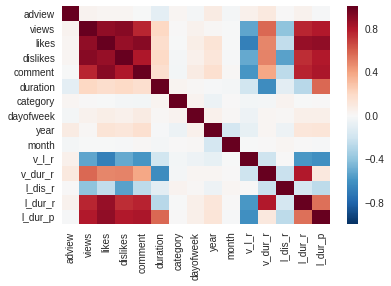

In [898]:
sns.heatmap(train.corr())

In [899]:
train.head()

,adview,views,likes,dislikes,comment,duration,category,dayofweek,year,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p
0,3.713572,13.846624,9.050641,5.897154,6.999422,6.126869,5,2,2016,9,1.529905,2.259984,1.534747,1.477205,55.452093
1,1.098612,7.443078,4.043051,1.098612,1.945910,6.347389,3,5,2016,10,1.840956,1.172620,3.680144,0.636963,25.662820
2,0.693147,7.612831,3.258097,0.000000,1.098612,4.919981,2,5,2016,7,2.336589,1.547329,1.865335,0.662217,16.029773
3,1.945910,13.338863,6.656727,5.087596,5.036953,5.572154,7,2,2016,7,2.003817,2.393843,1.308423,1.194642,37.092306
4,0.693147,6.502790,0.693147,0.000000,0.000000,3.465736,3,2,2016,6,9.381543,1.876309,1.865335,0.200000,2.402265


In [900]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14637 entries, 0 to 14998
Data columns (total 15 columns):
adview       14637 non-null float64
views        14637 non-null float64
likes        14637 non-null float64
dislikes     14637 non-null float64
comment      14637 non-null float64
duration     14637 non-null float64
category     14637 non-null int64
dayofweek    14637 non-null int64
year         14637 non-null int64
month        14637 non-null int64
v_l_r        14637 non-null float64
v_dur_r      14637 non-null float64
l_dis_r      14637 non-null float64
l_dur_r      14637 non-null float64
l_dur_p      14637 non-null float64
dtypes: float64(11), int64(4)
memory usage: 1.8 MB


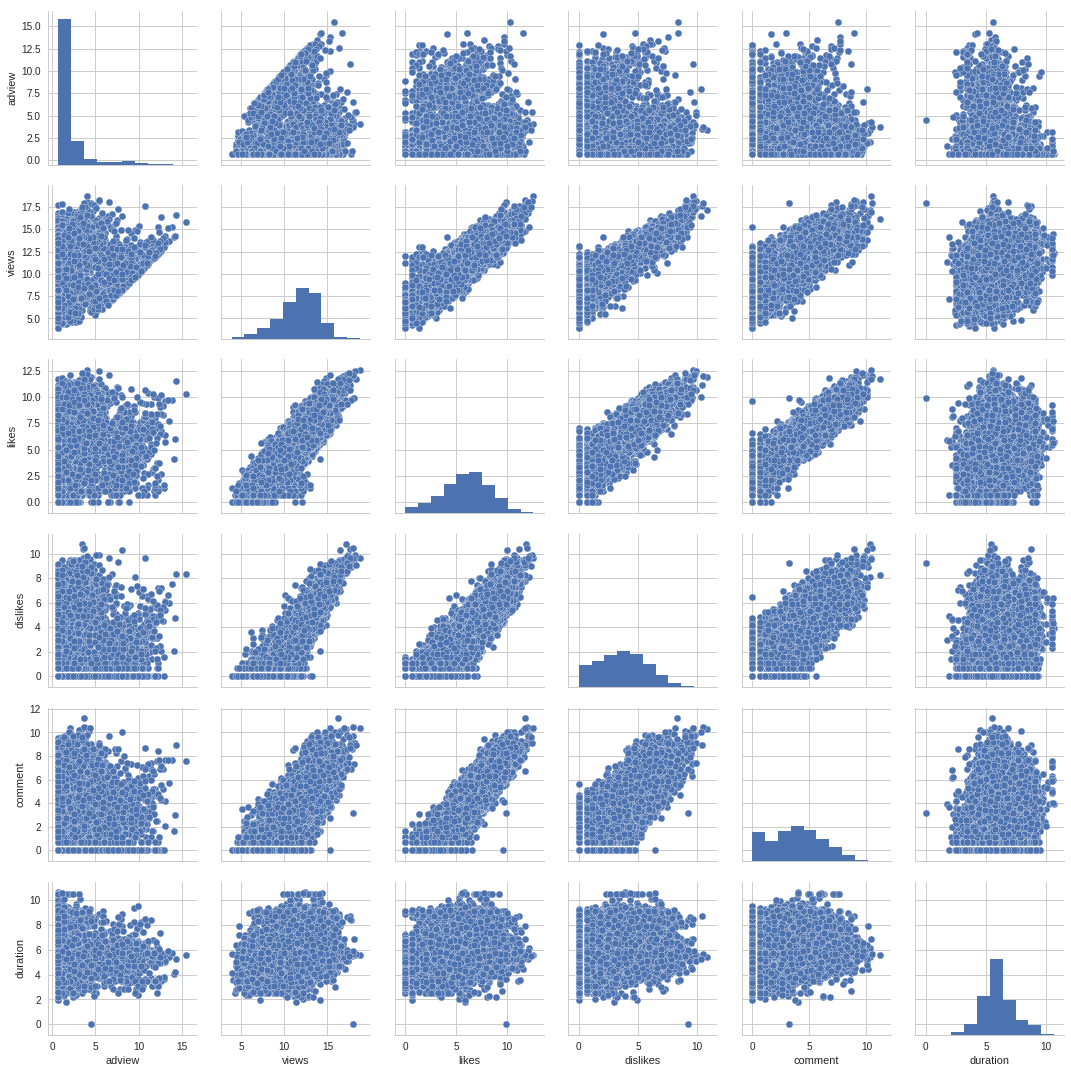

In [863]:
sns.pairplot(train[columns])
#the small duration is probably an outlier - can be changed to mean

In [901]:
y_train = train['adview']
train.drop(['adview'],axis =1, inplace=True)

Random Forests
MAE : 1.046171
RMSE : 1.701392
Auc: 39.762451


model_score 0.895625295231


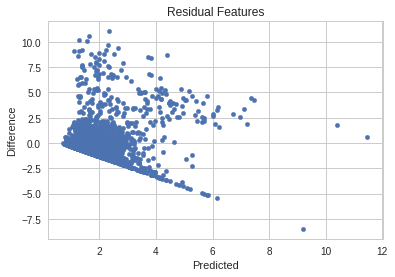

Ridge Regression
MAE : 1.200864
RMSE : 1.943677
Auc: 25.493653


model_score 0.0360820599198


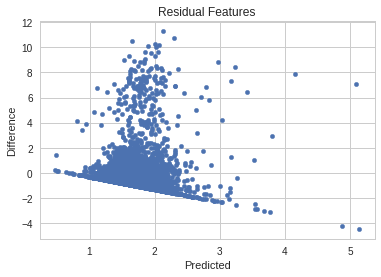

Lasso Regression
MAE : 1.209572
RMSE : 1.961303
Auc: 23.136939


model_score 0.0101804148535


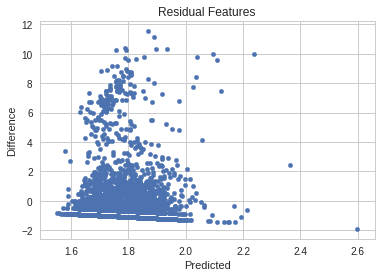

MLP (NN)
MAE : 1.205484
RMSE : 1.963917
Auc: 23.101091


model_score 0.00886076241506


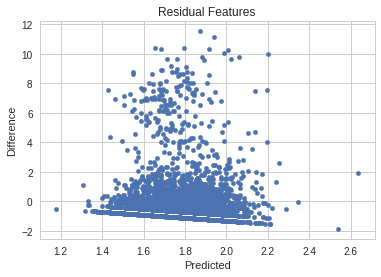

In [902]:
def display_metrics(y_test, y_pred):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    #print ("NRMSE : %f" % np.mean(np.abs((y_test - y_pred)/y_test)) * 100)
    print ("Auc: %f" % metrics.auc(y_test, y_pred,reorder=True))
    #print ("fbeta: %f" % metrics.fbeta_score(y_test, y_pred, beta=2))
    print ("\n")
           
def model_train(model,X,y):
    # Split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    
    print ('model_score', model.score(X_train, y_train))
    
    plt.figure(figsize= (50,10))
    preds = pd.DataFrame({"Predicted":model.predict(X_test), "true":y_test})
    preds["Difference"] = preds["true"] - preds["Predicted"]
    preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")
    plt.show()
    
def training(X,y):   
    
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_estimators = 300,max_features='sqrt')
    print ("Random Forests")
    model_train(rand_clf, X, y)

    #Ridge Regression
    ridge_clf = Ridge(alpha=0.001, normalize=True)
    print ("Ridge Regression")
    model_train(ridge_clf, X, y)
    
    #Lasso Regression
    lasso_clf = Lasso(alpha=0.001, normalize=True)
    print ("Lasso Regression")
    model_train(lasso_clf, X, y)
    
    #MLP Regression
    mlp_clf = MLPRegressor(solver = 'lbfgs', alpha = 0.01, hidden_layer_sizes=(10,10), random_state= 1)
    print ("MLP (NN)")
    model_train(mlp_clf, X, y)
    
    
    return rand_clf, mlp_clf, ridge_clf, lasso_clf

rand_reg,ridge_reg, lasso_reg, mlp_reg = training(train, y_train)


In [903]:
X_train, X_test, y_train, y_test = train_test_split(train,y_train,test_size=0.2, random_state = 1)

In [904]:
random_forest = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators=300)

In [905]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [906]:
y_pred = random_forest.predict(X_test)

In [907]:
random_forest.score(X_train, y_train)

0.89610950137864664

In [908]:
random_forest.score(X_test,y_test)

0.27941972032645479

In [909]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(train.columns)
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(random_forest.feature_importances_)

# preview
coeff_df

,Features,Coefficient Estimate
0,views,0.150208
1,likes,0.046994
2,dislikes,0.055775
3,comment,0.068938
4,duration,0.072545
5,category,0.053528
6,dayofweek,0.037028
7,year,0.081515
8,month,0.055703
9,v_l_r,0.085145


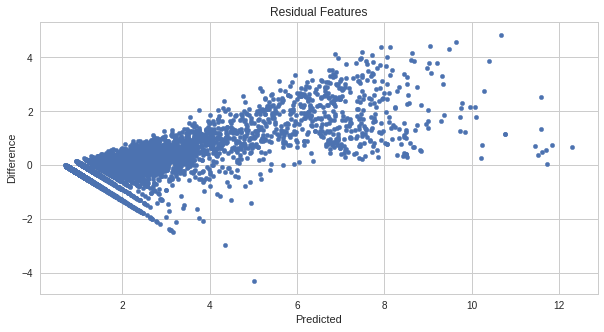

In [915]:
#Remaining Feature Set
plt.figure(figsize= (50,10))
preds = pd.DataFrame({"Predicted":random_forest.predict(X_train), "true":y_train})
preds["Difference"] = preds["true"] - preds["Predicted"]
preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features",figsize=(10,5))

In [485]:
random_forest.criterion

'mse'